<a href="https://colab.research.google.com/github/CChenLi/Python/blob/master/XNN_reproduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import pandas as pd
import numpy as np

import torch 
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data   
import torch.nn as nn 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import r2_score
from sklearn import linear_model
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

import time
import torchvision
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [43]:
df = pd.read_csv("drive/My Drive/ParisLab/collection2.csv")

In [44]:
# MODE = "selection"
MODE = "non-selection"
LR = 0.001
EP = 1000
WD = 0.01
BS = 16
CHANNEL = 6

In [45]:
def stratification(Y, n=10, test_ratio=0.1, rnd=1, ind=0):
    Y_train=pd.DataFrame([])
    Y_test=pd.DataFrame([])
    for count,i in enumerate(np.linspace(min(Y.iloc[:,ind]),max(Y.iloc[:,ind]),n)): # rank by y values
        if count==0:
            Y_train=pd.concat([Y_train,Y.loc[Y.iloc[:,ind].nsmallest(n=1).index]])
            j=i
        else:
            Y_sp = Y[(Y.iloc[:,ind] > j) & (Y.iloc[:,ind] <= i)] #  & (data_raw.iloc[:,[-2]] < data_raw.iloc[len(data_raw)-1,[-2]])
            Y_train_sp, Y_test_sp = train_test_split(Y_sp, test_size = test_ratio, random_state = rnd+count) # random_state = l+80
            Y_train=pd.concat([Y_train,Y_train_sp])
            Y_test=pd.concat([Y_test,Y_test_sp])
            j=i
    del count, i, j, Y_train_sp, Y_test_sp, Y_sp
    return Y_train, Y_test


# Model

In [46]:
df = df[['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O', 'Constraint number, Nc']]
trainset, testset = stratification(df, n=6, test_ratio=0.2, ind=6)

In [47]:
X_raw = trainset[['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O']]
y_raw = trainset['Constraint number, Nc']
X_test = testset[['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O']]
y_test = testset['Constraint number, Nc']
y_mean = np.mean(y_raw)
scaler1 = preprocessing.StandardScaler() # z = (x - u) / s normalization
X_train = scaler1.fit_transform(X_raw) 
X_train = pd.DataFrame(X_train)
X_test = scaler1.fit_transform(X_test)  
X_test = pd.DataFrame(X_test)

scaler2 = preprocessing.StandardScaler()
y_train = scaler2.fit_transform(y_raw.values.reshape(-1, 1))
y_train = pd.Series(np.squeeze(y_train))
y_test = scaler2.fit_transform(y_test.values.reshape(-1, 1))
y_test = pd.Series(np.squeeze(y_test))

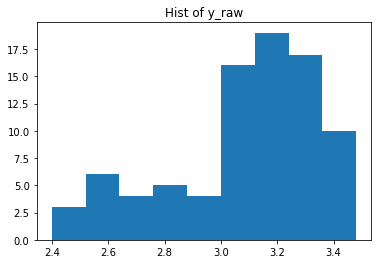

In [48]:
_ = plt.hist(y_raw, bins='auto')
_ = plt.title("Hist of y_raw")

In [49]:
'''
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, 
                                                    test_size=0.2,
                                                    stratify=y_scaled,
                                                    random_state=1)

X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)
'''

'\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, \n                                                    test_size=0.2,\n                                                    stratify=y_scaled,\n                                                    random_state=1)\n\nX_train = X_train.reset_index(drop=True)\nX_test  = X_test.reset_index(drop=True)\n\ny_train = y_train.reset_index(drop=True)\ny_test  = y_test.reset_index(drop=True)\n'

In [50]:
# Need this to override ToTensor()
class ToTensor(object):
    def __call__(self, sample):
      return torch.from_numpy(sample).to(device)

In [51]:
transform = transforms.Compose([transforms.ToTensor()])

# fly ash dataset
class FLYASHDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.X = images
        self.y = labels
        self.transform = transform
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i, :]
        data = np.asarray(data).reshape(1, CHANNEL, 1)
        
        if self.transform:
            data = self.transform(data)
            
        if self.y is not None:
            return (data.float(), self.y[i])
        else:
            return data.float()
 
train_data = FLYASHDataset(X_train, y_train, transform)
test_data = FLYASHDataset(X_test, y_test, transform)
 
# dataloaders
train_loader = DataLoader(train_data, batch_size=BS, shuffle=True,drop_last=True)
test_loader = DataLoader(test_data, batch_size=BS, shuffle=False,drop_last=False)

input_shape = np.array(train_data[0][0]).shape
input_dim = input_shape[1]*input_shape[2]*input_shape[0]
print(input_shape)
print(input_dim)

(1, 1, 6)
6


In [52]:
class Sub_model(nn.Module):
  def __init__(self):
    super(Sub_model, self).__init__()
    self.main = nn.Sequential(
    nn.Linear(1, 2),
    nn.BatchNorm1d(2),
    nn.ReLU(inplace=True), 
    nn.Linear(2, 4),
    nn.BatchNorm1d(4),
    nn.ReLU(inplace=True),
    nn.Linear(4, 1),
    nn.BatchNorm1d(1),
    nn.ReLU(inplace=True), 
  )
  def forward(self, x):
    return self.main(x)


'''
sub_model = nn.Sequential(
    nn.Linear(1, 4),
    nn.BatchNorm1d(4),
    nn.ReLU(inplace=True), 
    nn.Linear(4, 2),
    nn.BatchNorm1d(2),
    nn.ReLU(inplace=True), 
    nn.Linear(2, 1),
    nn.BatchNorm1d(1),
    nn.ReLU(inplace=True),
)
'''
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [53]:
GLOBAL_INPUTS = []
GLOBAL_OUTPUTS = []

class MainModel(nn.Module):
    def __init__(self, input_nodes):
        super(MainModel, self).__init__()
        self.input_nodes = input_nodes
        self.networks = nn.ModuleList()
        self.networks.extend(Sub_model() for i in range(input_nodes))
        self.selection_weight = torch.nn.Parameter(torch.rand(CHANNEL, input_nodes, 1))
        # self.selection_weight = [nn.Linear(2, 1), nn.Linear(2,1)]
 
        # Final neural net created here
        
        '''
        self.main = nn.Sequential(
          nn.Linear(input_nodes, input_nodes),
          nn.BatchNorm1d(input_nodes),
          nn.ReLU(inplace=True),
          nn.Linear(input_nodes, 1),
        )
        '''
        self.main = nn.Linear(input_nodes, 1)
        self.main.apply(init_weights)
        
    
    def forward(self, input):   
      input = input.view(input.size(0),-1)
      feature_list = [] 
      for i in range(0, self.input_nodes):
        
        if MODE == "selection":
          feature_list.append(self.networks[i](torch.matmul(input,
                              (self.selection_weight[i,:]))))
        if MODE == "non-selection":
          feature_list.append(self.networks[i](input[:,i].reshape(-1,1)))

      GLOBAL_INPUTS.append(input)
      GLOBAL_OUTPUTS.append(feature_list)

      x = torch.cat(feature_list ,dim=1)
      x1 = self.main(x)
      return x1

In [54]:
def save_model(model, name=""):
  torch.save(model.state_dict(), name + MODE + ".pickle")

def load_model(path="drive/My Drive/ParisLab/models/selection.pickle"):
  model = MainModel(input_dim)
  model.load_state_dict(torch.load(path))
  model.eval()
  return model

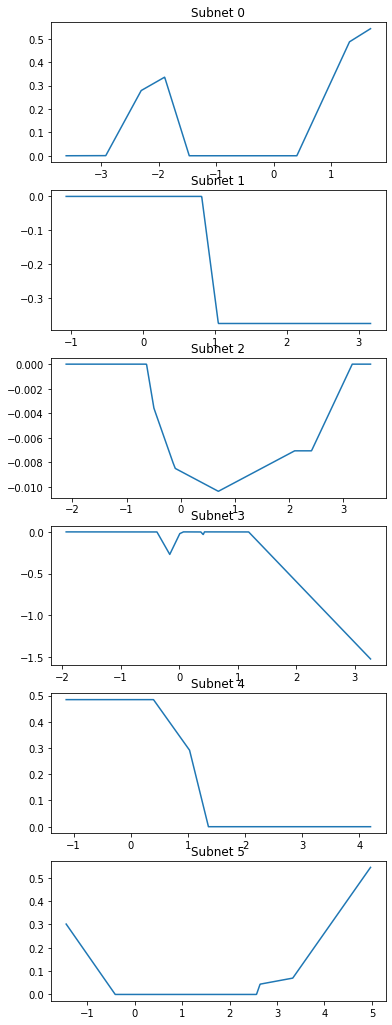

In [55]:
net = MainModel(CHANNEL)
datas = scaler1.fit_transform(X_raw)
fig = plt.figure(figsize=[6, 18])
for i, subnet in enumerate(net.networks):
  lbound = min(datas[:,i])
  ubound = max(datas[:,i])
  fig.add_subplot(CHANNEL, 1, i+1)
  plt.plot(np.linspace(lbound, ubound, 1000),
           net.main.weight[0][i].detach()*subnet(torch.unsqueeze(torch.linspace(lbound, ubound, 1000), 1)).detach())
  plt.title(f"Subnet {i}" )
plt.savefig("Subnet.jpg")

In [56]:
# net2 = load_model("/content/drive/My Drive/ParisLab/models/week2.pickle")

In [57]:
loss_func = torch.nn.MSELoss()  

In [58]:
def train(model, train_loader, test_loader, loss_func, num_epochs=EP, learningrate=LR):
  all_training_loss = np.zeros((0,2))
  all_test_loss = np.zeros((0,2))
  opt = torch.optim.Adam(model.parameters(), lr=learningrate)
  
  training_step = 1
  training_loss = 0.0
  print_every = 1000
  
  start = time.clock()
  
  for i in range(num_epochs):
    epoch_start = time.clock() 
   
    model.train()
    for images, labels in train_loader:
      opt.zero_grad()
      #print(images.view(images.size(0),-1)[:,i].reshape(-1,1))
      #print(images.view(images.size(0),-1).shape)
      #return

      preds = np.squeeze(model(images)).double() # need double()
      if MODE == "selection":
        loss = loss_func(preds, labels) + \
        WD*torch.sum(torch.abs(net.selection_weight.view(-1)))
      if MODE == "non-selection":
        loss = loss_func(preds, labels)
      loss.backward()
      opt.step()

      
      training_loss += loss.item()
      if training_step % print_every == 0:
        training_loss /= print_every      
        all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
        
        print('  Epoch %d @ step %d: Train Loss: %3f' % (i, training_step, training_loss))
        training_loss = 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss = 0.0
      count = 0
      for images, labels in test_loader:
        output = np.squeeze(model(images))
        validation_loss += loss_func(output,labels)
        count += 1

      validation_loss /= count     
      all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
      
      epoch_time = time.clock() - epoch_start
      if(i % 10 == 0):
        print('Epoch %d Test Loss: %3f,  time: %.1fs' % (i, validation_loss, epoch_time))
      
  total_time = time.clock() - start
  print('Final Test Loss: %3f, Total time: %.1fs' % (validation_loss, total_time))

  return {'Train': { 'train': all_training_loss, 'test': all_test_loss }}


# Train

In [59]:
metrics = train(net, train_loader, test_loader, loss_func, 
                learningrate=LR)

Epoch 0 Test Loss: 1.078489,  time: 0.1s
Epoch 10 Test Loss: 0.751848,  time: 0.1s
Epoch 20 Test Loss: 0.481999,  time: 0.1s
Epoch 30 Test Loss: 0.491590,  time: 0.1s
Epoch 40 Test Loss: 0.332638,  time: 0.1s
Epoch 50 Test Loss: 0.347807,  time: 0.1s
Epoch 60 Test Loss: 0.325185,  time: 0.1s
Epoch 70 Test Loss: 0.335733,  time: 0.1s
Epoch 80 Test Loss: 0.381229,  time: 0.1s
Epoch 90 Test Loss: 0.412589,  time: 0.1s
Epoch 100 Test Loss: 0.348649,  time: 0.1s
Epoch 110 Test Loss: 0.337800,  time: 0.1s
Epoch 120 Test Loss: 0.303106,  time: 0.1s
Epoch 130 Test Loss: 0.304983,  time: 0.1s
Epoch 140 Test Loss: 0.297942,  time: 0.1s
Epoch 150 Test Loss: 0.302698,  time: 0.1s
Epoch 160 Test Loss: 0.292527,  time: 0.1s
Epoch 170 Test Loss: 0.286755,  time: 0.1s
Epoch 180 Test Loss: 0.268761,  time: 0.1s
Epoch 190 Test Loss: 0.250600,  time: 0.1s
  Epoch 199 @ step 1000: Train Loss: 0.414622
Epoch 200 Test Loss: 0.258493,  time: 0.1s
Epoch 210 Test Loss: 0.355490,  time: 0.1s
Epoch 220 Test Loss

# Compare with generating function

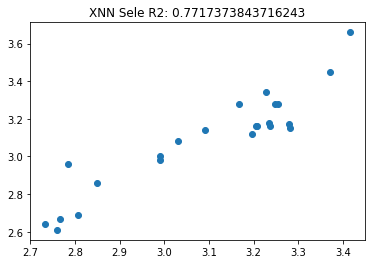

In [60]:
final_pred = np.array([])
final_true = np.array([])
image = 0

for images, labels in test_loader:
      final_output = net(images)
      image = images
      final_pred = np.append(final_pred, final_output.detach().cpu().numpy())
      final_true = np.append(final_true, labels.detach().cpu().numpy())

final_pred_recover = scaler2.inverse_transform(final_pred)
final_true_recover = scaler2.inverse_transform(final_true)
plt.scatter(final_pred_recover, final_true_recover)
_ = plt.title("XNN Sele R2: " + str(r2_score(final_pred, final_true)))
plt.savefig("XNN Stratified Sele.jpg")

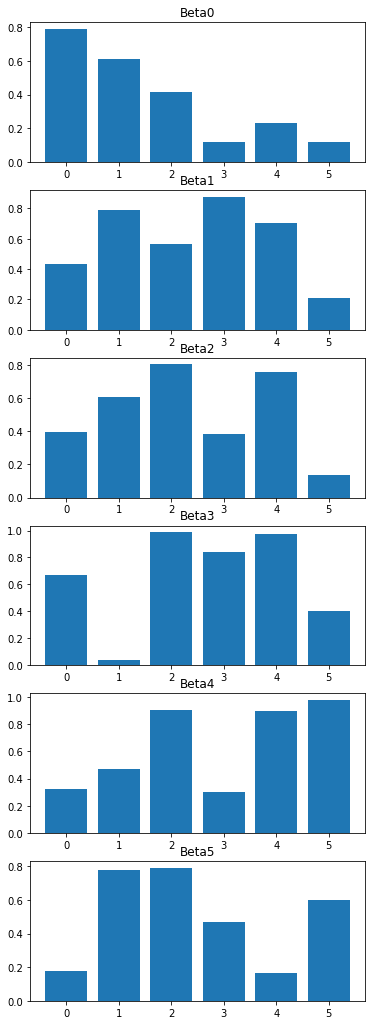

In [61]:
fig = plt.figure(figsize=[6, 18])
for i, beta in enumerate(net.selection_weight):
  fig.add_subplot(input_dim, 1, i+1)
  plt.bar(range(input_dim), beta.squeeze().detach())
  plt.title(f"Beta{i}" )
plt.savefig("beta.jpg")

# temp

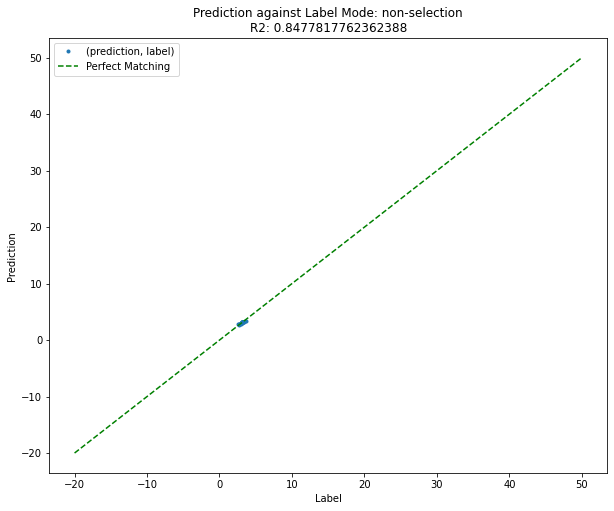

In [62]:
plt.figure(figsize=(10,8))
xdot = np.linspace(-20, 50, 1000)
#sns.scatterplot(final_true_recover, final_pred_recover, label="(prediction, label)")
plt.plot(final_true_recover, final_pred_recover, ".", label="(prediction, label)")
plt.plot(xdot, xdot, "g--", label="Perfect Matching")
plt.title('Prediction against Label Mode: ' + MODE + '\nR2: ' + str(r2_score(final_true_recover, final_pred_recover)))
plt.legend()
plt.ylabel('Prediction')
plt.xlabel('Label')

plt.savefig("fig1")

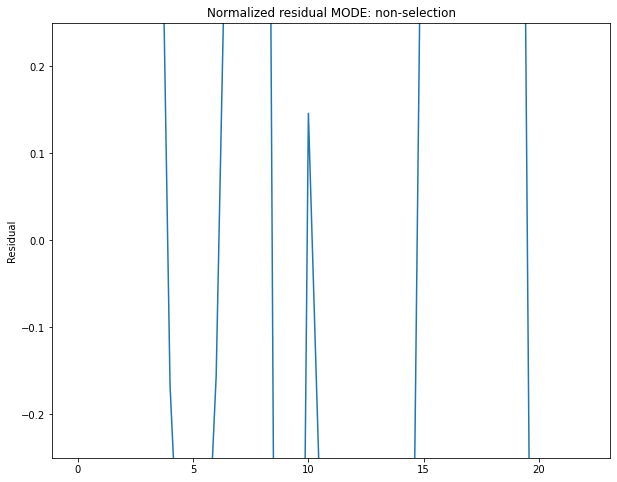

In [63]:
plt.figure(figsize=(10,8))
plt.plot((final_pred_recover - final_true_recover) / np.var(final_true_recover))
plt.ylim(-0.25, 0.25)
plt.ylabel("Residual")
plt.title("Normalized residual MODE: " + MODE)
plt.savefig("fig2")

In [64]:
'''
def f1(x):
  return 0.2+0.4*x**2-1.5*np.cos(5*x)+5*np.sin(x)+np.log(10*x+0.01)
def f2(x):
  return 3+0.3*x-0.1*(0.2*x)**4

def f1(x):
  return 4*x**2
def f2(x):
  return 20*np.sin(1/10*x)

def f1(x):
  return x**2
def f2(x):
  return -(0.25*(x+20))**2
'''
def f1(x):
  return 4000*torch.sin(1/10*x)
def f2(x):
  return -x**3
def f3(x):
  return 40*torch.exp(x)

In [65]:
x1_vector = torch.ones(CHANNEL, 1000)
x1_vector[0] = torch.linspace(-20,20,1000)
FirstQ = transform(scaler1.fit_transform(x1_vector.permute(1, 0)))
FirstQ = scaler2.inverse_transform(net(FirstQ.float()[0]).detach())
true_label = f1(x1_vector[0])

x2_vector = torch.ones(CHANNEL, 1000)
x2_vector[1] = torch.linspace(-20,20,1000)
FirstQ2 = transform(scaler1.fit_transform(x2_vector.permute(1, 0)))
FirstQ2 = scaler2.inverse_transform(net(FirstQ2.float()[0]).detach())
true_label2 = f2(x2_vector[1])

x3_vector = torch.ones(CHANNEL, 1000)
x3_vector[2] = torch.linspace(-5,5,1000)
FirstQ3 = transform(scaler1.fit_transform(x3_vector.permute(1, 0)))
FirstQ3 = scaler2.inverse_transform(net(FirstQ3.float()[0]).detach())
true_label3 = f3(x3_vector[2])

In [66]:
L21 = (true_label - np.asarray(FirstQ).reshape(-1)).square().sum().sqrt() / 1000
L22 = (true_label2 - np.asarray(FirstQ2).reshape(-1)).square().sum().sqrt() / 1000

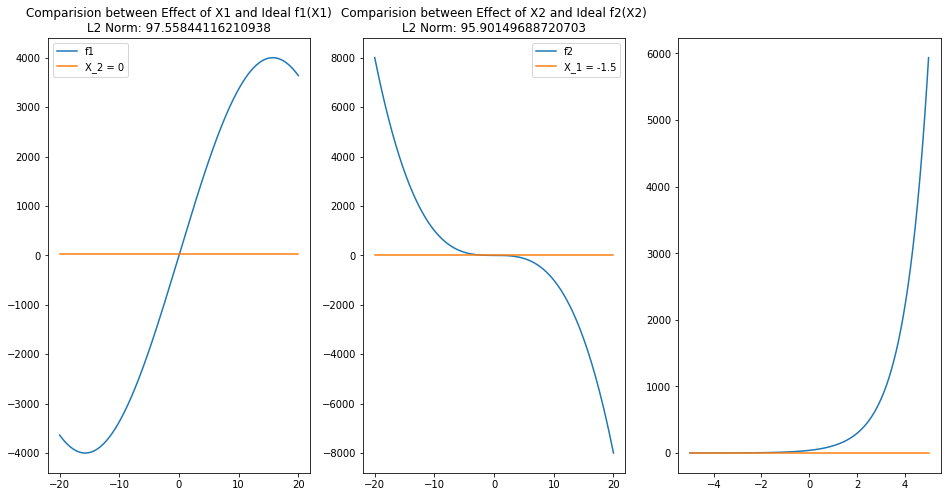

In [67]:
fig = plt.figure(figsize=[16, 8])
fig.add_subplot(1, 3, 1)
# plt.figure(figsize=(10,8))
# plt.plot(x1_vector, y_mean*np.ones(1000))
plt.plot(x1_vector[0], true_label, label="f1")
plt.plot(x1_vector[0], FirstQ+20, label="X_2 = 0")

#plt.ylim(-20, 50)
plt.legend()
plt.title("Comparision between Effect of X1 and Ideal f1(X1)\nL2 Norm: " + str(L21.item()))# + "\n R2: " + str(r2_score(true_label, FirstQ)))

fig.add_subplot(1, 3, 2)
# plt.plot(x2_vector, y_mean*np.ones(1000))
plt.plot(x2_vector[1], true_label2, label="f2")
# plt.plot(x2_vector, FirstQ2, label="X_1 = 0")
plt.plot(x2_vector[1], FirstQ2, label="X_1 = -1.5")
#plt.ylim(-50, 50)
plt.legend()
plt.title("Comparision between Effect of X2 and Ideal f2(X2)\nL2 Norm: "+ str(L22.item()))# + "\n R2: " + str(r2_score(true_label2, FirstQ2)))
fig.add_subplot(1, 3, 3)
# plt.figure(figsize=(10,8))
# plt.plot(x1_vector, y_mean*np.ones(1000))
plt.plot(x3_vector[2], true_label3, label="f3")
plt.plot(x3_vector[2], FirstQ3, label="X_2 = 0")

plt.savefig("figure3")

In [68]:
net.eval()

MainModel(
  (networks): ModuleList(
    (0): Sub_model(
      (main): Sequential(
        (0): Linear(in_features=1, out_features=2, bias=True)
        (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Linear(in_features=2, out_features=4, bias=True)
        (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Linear(in_features=4, out_features=1, bias=True)
        (7): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
    )
    (1): Sub_model(
      (main): Sequential(
        (0): Linear(in_features=1, out_features=2, bias=True)
        (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Linear(in_features=2, out_features=4, bias=True)
        (4): BatchNorm1d(4, eps=1e-05, momentum=0.1

In [69]:
base = torch.ones(CHANNEL, 1000)
base[0] = torch.linspace(-20,20,1000)
base

tensor([[-20.0000, -19.9600, -19.9199,  ...,  19.9199,  19.9600,  20.0000],
        [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000],
        [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000],
        [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000],
        [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000],
        [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000]])

# Linear regression

0.818681595758993


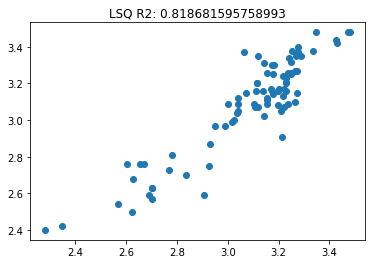

In [70]:
regr = linear_model.LinearRegression()
regr.fit(X_raw, y_raw)
y_pred = regr.predict(X_raw)
print(r2_score(y_pred, y_raw))
plt.scatter(y_pred, y_raw)
_ = plt.title("LSQ R2: " + str(r2_score(y_pred, y_raw)))
plt.savefig("LSQ.jpg")

# MLP

In [71]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(CHANNEL, 2*CHANNEL),
            nn.ReLU(),
            nn.Linear(2*CHANNEL, 1)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

In [72]:
mlp = MLP()

In [73]:
'''
metrics = train(mlp, train_loader, test_loader, loss_func, 
                learningrate=5*LR)
'''

'\nmetrics = train(mlp, train_loader, test_loader, loss_func, \n                learningrate=5*LR)\n'

In [74]:
'''
final_pred = np.array([])
final_true = np.array([])
image = 0

for images, labels in test_loader:
      final_output = mlp(images)
      image = images
      final_pred = np.append(final_pred, final_output.detach().cpu().numpy())
      final_true = np.append(final_true, labels.detach().cpu().numpy())

final_pred_recover = scaler2.inverse_transform(final_pred)
final_true_recover = scaler2.inverse_transform(final_true)
plt.scatter(final_pred_recover, final_true_recover)
_ = plt.title("MLP R2: " + str(r2_score(final_pred, final_true)))
plt.savefig("MLP.jpg")
'''

'\nfinal_pred = np.array([])\nfinal_true = np.array([])\nimage = 0\n\nfor images, labels in test_loader:\n      final_output = mlp(images)\n      image = images\n      final_pred = np.append(final_pred, final_output.detach().cpu().numpy())\n      final_true = np.append(final_true, labels.detach().cpu().numpy())\n\nfinal_pred_recover = scaler2.inverse_transform(final_pred)\nfinal_true_recover = scaler2.inverse_transform(final_true)\nplt.scatter(final_pred_recover, final_true_recover)\n_ = plt.title("MLP R2: " + str(r2_score(final_pred, final_true)))\nplt.savefig("MLP.jpg")\n'

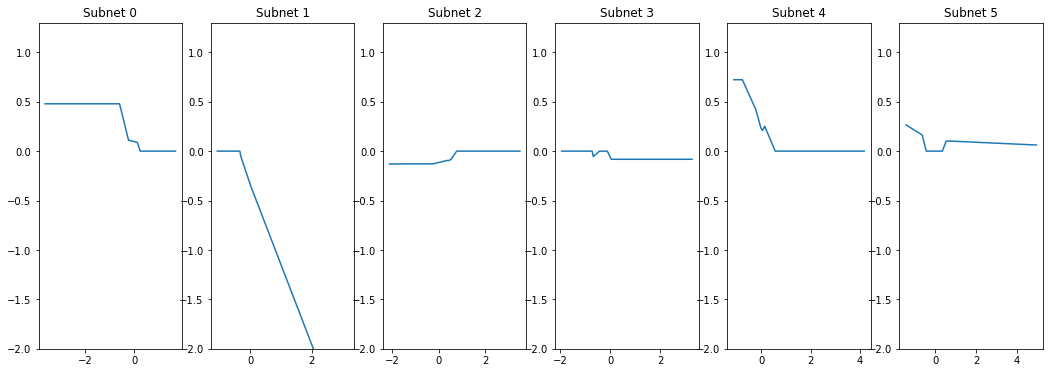

In [75]:
datas = scaler1.fit_transform(X_raw)
fig = plt.figure(figsize=[18, 6])
for i, subnet in enumerate(net.networks):
  lbound = min(datas[:,i])
  ubound = max(datas[:,i])
  fig.add_subplot(1, CHANNEL, i+1)
  plt.plot(np.linspace(lbound, ubound, 1000),
           net.main.weight[0][i].detach()*subnet(torch.unsqueeze(torch.linspace(lbound, ubound, 1000), 1)).detach())
  plt.ylim(-2, 1.3)
  plt.title(f"Subnet {i}" )
plt.savefig("Subnet.jpg")

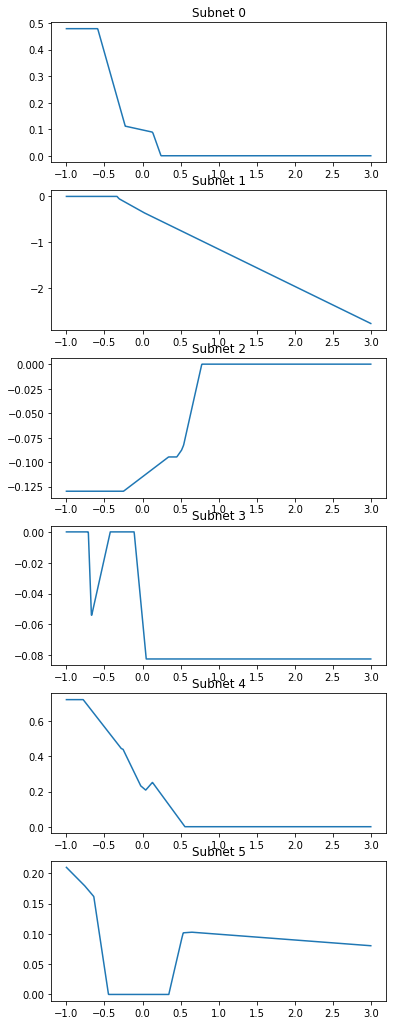

In [76]:
fig = plt.figure(figsize=[6, 18])
for i, subnet in enumerate(net.networks):
  lbound = min(datas[:,i])
  ubound = max(datas[:,i])
  fig.add_subplot(CHANNEL, 1, i+1)
  plt.plot(np.linspace(-1, 3, 1000),
           net.main.weight[0][i].detach()*net.networks[i](torch.unsqueeze(torch.linspace(-1, 3, 1000), 1)).detach())
  plt.title(f"Subnet {i}" )

In [ ]:
trains = 30
result = np.zeros([trains, CHANNEL, 500])
datas = scaler1.fit_transform(X_raw)
for j in range(trains):
  temp_net = MainModel(CHANNEL)
  metrics = train(temp_net, train_loader, test_loader, loss_func, learningrate=LR)
  for i, subnet in enumerate(temp_net.networks):
    lbound = 0.8* min(datas[:,i]) + 0.2*max(datas[:,i])
    ubound = 0.2* min(datas[:,i]) + 0.8*max(datas[:,i])
    result[j][i] = np.squeeze(temp_net.main.weight[0][i]
                              .detach()*temp_net.networks[i](torch.unsqueeze(torch.linspace(lbound, ubound, 500), 1)).detach())

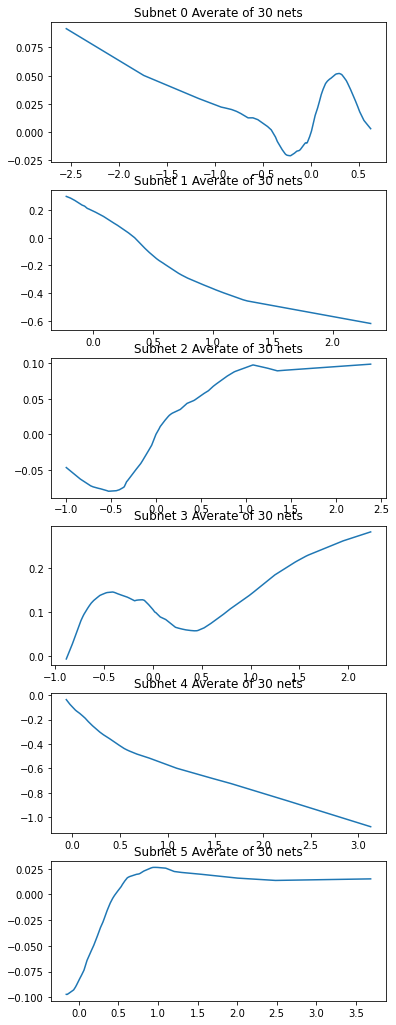

In [38]:
results = result.mean(0)
fig = plt.figure(figsize=[6, 18])
for i, subnet in enumerate(net.networks):
  fig.add_subplot(CHANNEL, 1, i+1)
  lbound = 0.8* min(datas[:,i]) + 0.2*max(datas[:,i])
  ubound = 0.2* min(datas[:,i]) + 0.8*max(datas[:,i])
  plt.plot(np.linspace(lbound, ubound, 500), results[i])
  plt.title(f"Subnet {i} Averate of {trains} nets" )
plt.savefig("Averaged.jpg")

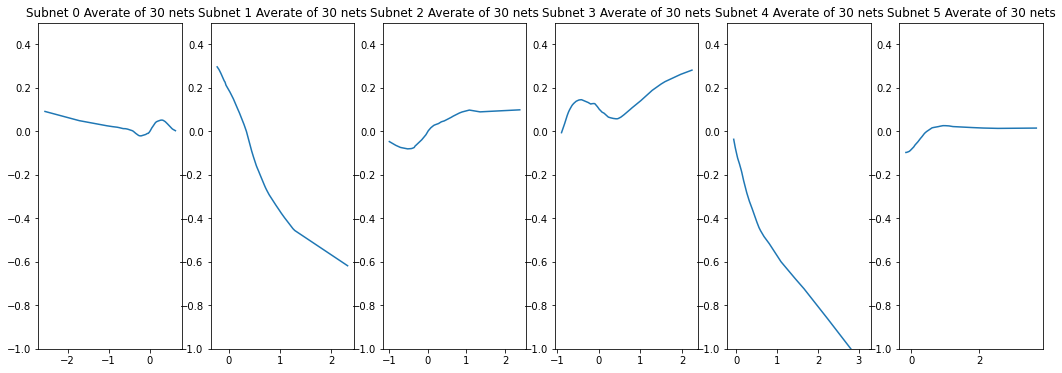

In [79]:
fig = plt.figure(figsize=[18, 6])
for i, subnet in enumerate(net.networks):
  fig.add_subplot(1, CHANNEL, i+1)
  lbound = 0.8* min(datas[:,i]) + 0.2*max(datas[:,i])
  ubound = 0.2* min(datas[:,i]) + 0.8*max(datas[:,i])
  plt.plot(np.linspace(lbound, ubound, 500), results[i])
  plt.ylim(-1, 0.5)
  plt.title(f"Subnet {i} Averate of {trains} nets" )
plt.savefig("Averaged2.jpg")